In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

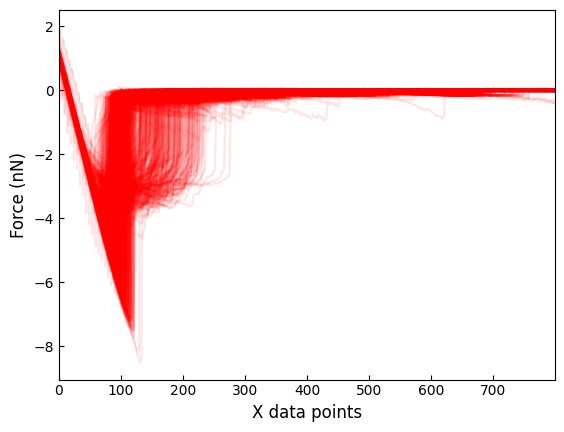

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Separar as 100 primeiras séries temporais pq talvez o código não tanke com mais que isso.

In [8]:
train_set = force_data[:100]
test_set = force_data[100:]

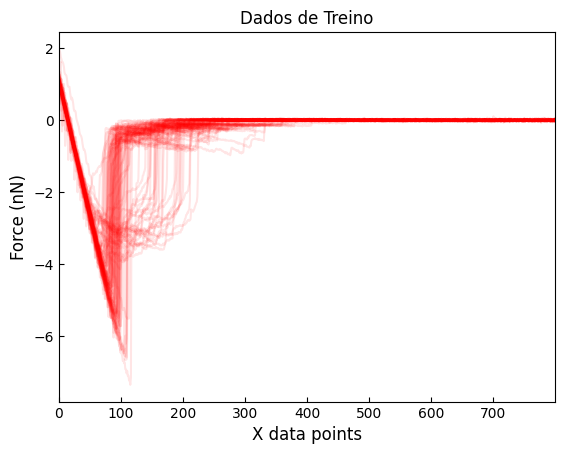

In [9]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
len(train_set[0])

800

In [11]:
# train_set_cort = np.zeros((100,450))

# for i in range(len(train_set_cort)):
#     train_set_cort[i] = train_set[i][:450]

# train_set_cort

In [12]:
# fig,ax = plt.subplots(dpi=100)

# for curve in train_set_cort:
#     ax.plot(curve,c='red',alpha=0.1)

# ax.set_xlabel('X data points',fontsize=12)
# ax.set_ylabel('Force (nN)',fontsize=12)

# ax.tick_params(labelsize=10,direction='in')

# ax.set_xlim([0,train_set_cort.shape[1]-1])

# ax.set_title("Dados de Treino cortados")

# #fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

# plt.show()

### Concatenando os dados
Juntar tudo numa mesma série temporal, como indicado no artigo.

In [13]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [14]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

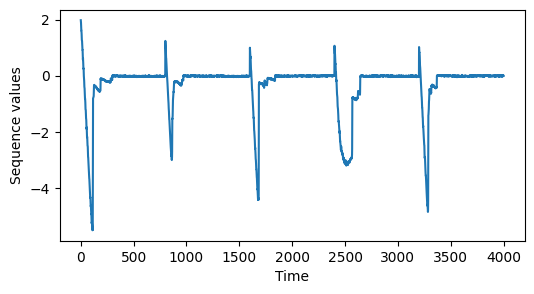

In [15]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [16]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 47.9 s, sys: 480 ms, total: 48.4 s
Wall time: 48.4 s


In [17]:
print(mp[1])

[23987. 23988. 23989. ... 51997. 51998. 51999.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

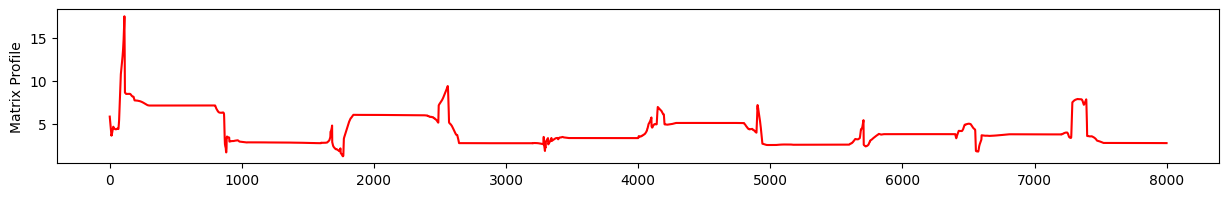

In [18]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [19]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 184 ms, sys: 75.9 ms, total: 259 ms
Wall time: 203 ms


38

Criando uma lista com os centros de motifs.

In [20]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [21]:
len(motif_center_list)

38

### Treinando a rede DTW-SOM

In [22]:
%time
rows = 2
cols = 2
structure = type_conn.grid_eight
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [23]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 9.6853
Epoch 2 achieved an average quantization error of 10.4506
Epoch 3 achieved an average quantization error of 11.2572
Epoch 4 achieved an average quantization error of 11.0932
Epoch 5 achieved an average quantization error of 11.1992
Epoch 6 achieved an average quantization error of 11.3653
Epoch 7 achieved an average quantization error of 11.3913
Epoch 8 achieved an average quantization error of 11.3509
Epoch 9 achieved an average quantization error of 11.3408
Epoch 10 achieved an average quantization error of 11.3209
Epoch 11 achieved an average quantization error of 11.2909
Epoch 12 achieved an average quantization error of 10.1464
Epoch 13 achieved an average quantization error of 8.956
Epoch 14 achieved an average quantization error of 8.3764
Epoch 15 achieved an average quantization error of 7.8934
Epoch 16 achieved an average quantization error of 7.5226
Epoch 17 achieved an average quantization error of 7.393
Epoch 18 achie

50

### Resultados

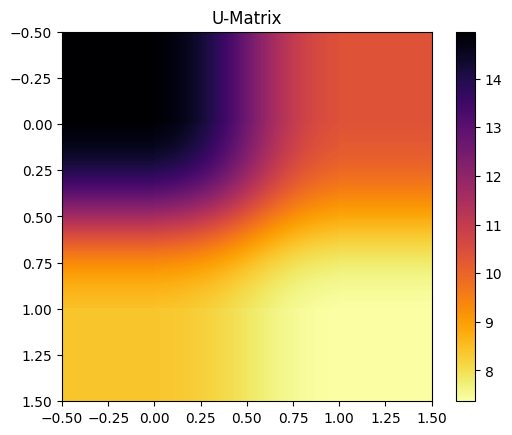

In [24]:
network.show_distance_matrix()

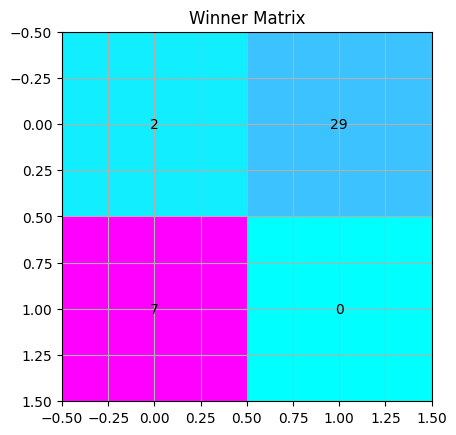

In [25]:
network.show_winner_matrix()

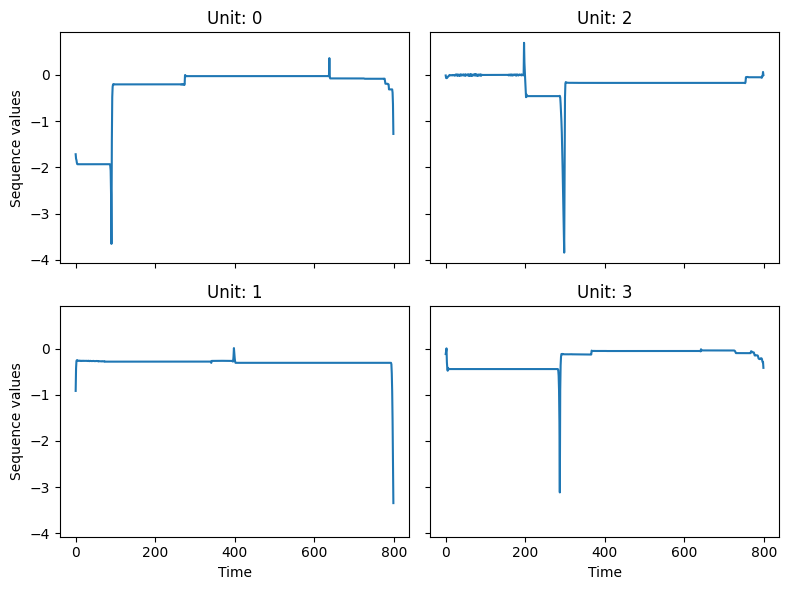

In [26]:
n_neurons = network._size
fig, axs = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

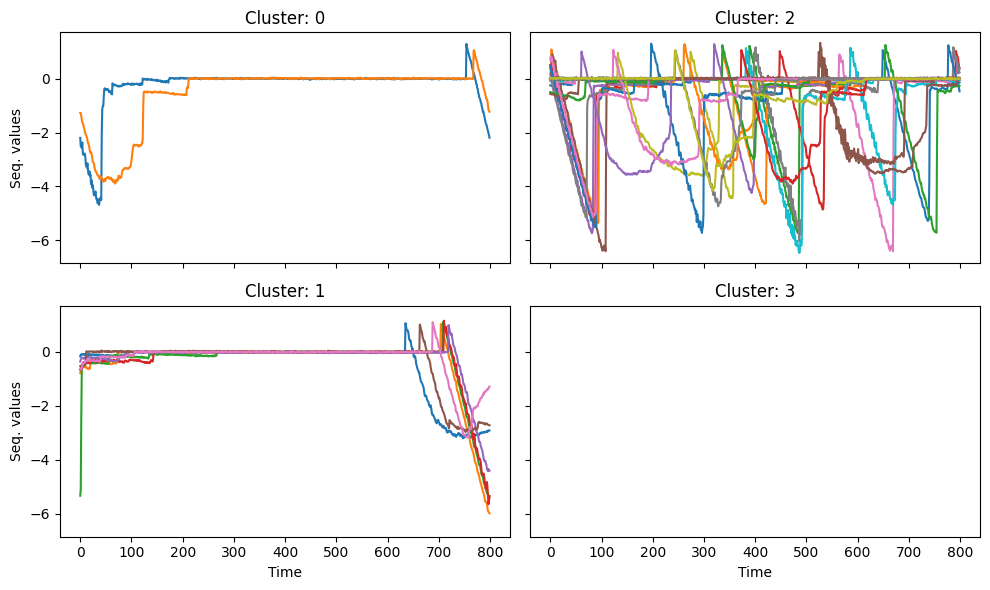

In [27]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

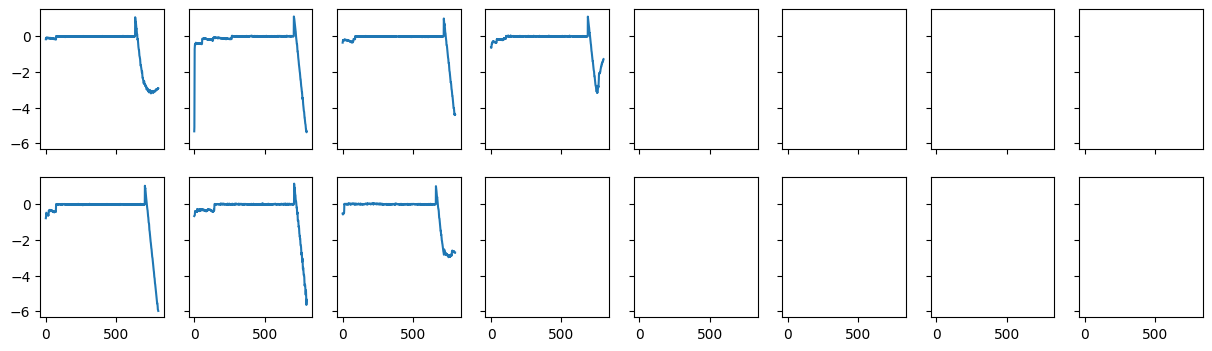

In [28]:
fig, axs = plt.subplots(2, 8,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[1]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

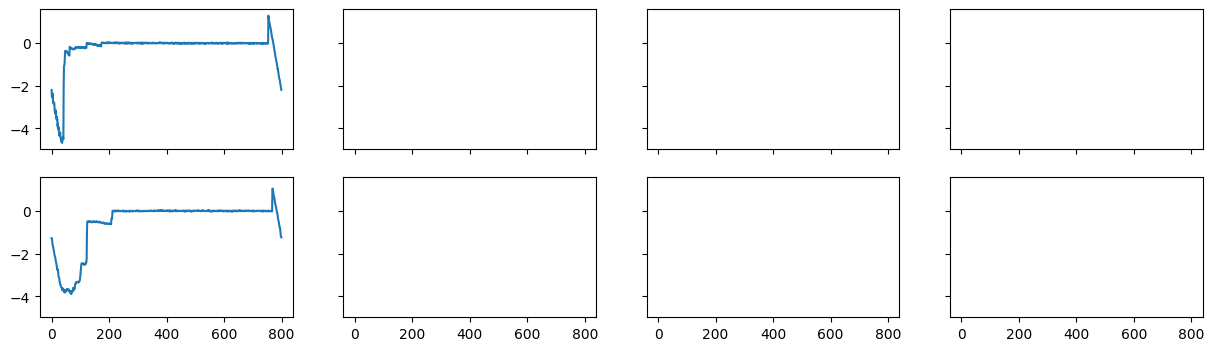

In [29]:
fig, axs = plt.subplots(2, 4,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[0]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

IndexError: list index out of range

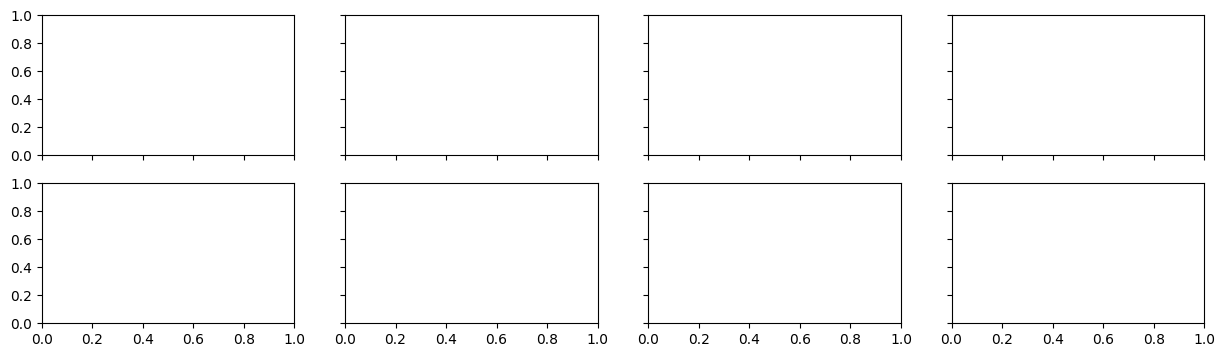

In [30]:
fig, axs = plt.subplots(2, 4,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[6]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[8]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

In [ ]:
def recupera_curvas_originais(joined_ts_data, unit, network, mtfs, size):
    id_motifs = network.capture_objects #indices dos motifs em cada unidade
    curvas = []
    for i in id_motifs[unit]: #pega o cluster de interesse
        motifs = mtfs[i] #recupera o indice dos motifs do cluster de interesse
        id_curva = 1
        for motif in motifs: #plota as curvas referentes a cada índice dos motifs do cluster de interesse
            x_ticks = np.arange(0, size, step=100)
            x_non_ticks = np.arange(motif, motif+size, step=100)

            plt.plot(joined_ts_data[motif:motif+size])
            plt.title(f"Curva {id_curva} do motif {i} do cluster {unit}")
            plt.xticks(x_ticks, x_non_ticks)
            plt.show()

            curvas.append(joined_ts_data[motif:motif+size])
            id_curva +=1

    return curvas  

In [ ]:
recupera_curvas_originais(joined_data, 4, network, mtfs, size)

In [ ]:
def recupera_ts(joined_ts_data, unit, network, mtfs, size, force_data):
    id_motifs = network.capture_objects #indices dos motifs em cada unidade
    curvas = []
    for i in id_motifs[unit]: #pega o cluster de interesse
        motifs = mtfs[i] #recupera o indice dos motifs do cluster de interesse
        for motif in motifs:
            p_min = min(joined_ts_data[motif:motif+size])
            p_min_index = list(joined_ts_data[motif:motif+size]).index(p_min)
            if p_min_index < 100:
                idx_curva = motif // size 
                curvas.append(force_data[idx_curva])
                plt.plot(force_data[idx_curva], color="r")
                plt.title(f"Série temporal {idx_curva} do conjunto de dados")
                plt.show()
            elif p_min_index >= 100 and p_min_index < 150:
                print(f"Duas curvas possíveis no motif {motif}")
                idx_curva_1 = motif // size 
                idx_curva_2 =motif // size + 1
                plt.plot(force_data[idx_curva_1], color="r")
                plt.title(f"Série temporal {idx_curva_1} do conjunto de dados")
                plt.show()
                plt.plot(force_data[idx_curva_2], color="r")
                plt.title(f"Série temporal {idx_curva_2} do conjunto de dados")
                plt.show()
                curvas.append([force_data[idx_curva_2], force_data[idx_curva_2]])
            else:
                idx_curva = motif // size + 1 
                plt.plot(force_data[idx_curva], color="r")
                plt.title(f"Série temporal {idx_curva} do conjunto de dados")
                plt.show()
                curvas.append(force_data[idx_curva])
                
    return curvas

In [ ]:
recupera_ts(joined_data, 4, network, mtfs, size, force_data)

In [ ]:
recupera_ts(joined_data, 1, network, mtfs, size, force_data)